In [1]:
import sys
import os
import importlib
import random
from itertools import combinations
import glob

import numpy as np
import scipy

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as pplt

import mdtraj as md
import MDAnalysis as mda

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
pplt.load_cmaps()

# Gating charge

In [4]:
topfile = "/project/dinner/scguo/ci-vsd/models/MD-clustering-center/civsd.psf"
u = mda.Universe(topfile, "/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.3.dcd")

In [5]:
def compute_displacement_charge(u, not_ions, ions):
    Lz = u.dimensions[2] # length of box
    q = 0
    # protein, lipid, water
    # for atom in u.select_atoms("not segid ION"):
    for atom in not_ions:
        q += atom.charge * (atom.position[2] + 0.5 * Lz) / Lz
    # ions, use unwrapped coordinates
    # for atom in u.select_atoms("segid ION"):
    for atom in ions:
        z = atom.position[2]
        if z > 0:
            z -= Lz
        q += atom.charge * (z + 1.0 * Lz) / Lz
    return q

In [6]:
def compute_displacement_charge_sel(u, sel):
    Lz = u.dimensions[2] # length of box
    q = 0
    # protein, lipid, water
    for atom in sel:
        q += atom.charge * (atom.position[2] + 0.5 * Lz) / Lz
    return q

In [9]:
# not_ions = u.select_atoms("not segid ION and (not protein and residue ")
# ions = u.select_atoms("segid ION")
sel = u.select_atoms("protein and resid 232")

r232q = np.empty(len(u.trajectory))
for i, _ in enumerate(u.trajectory):
    r232q[i] = compute_displacement_charge_sel(u, sel)

In [7]:
displacement_q = np.load("../../data/raw_feat/displacement_q_anton2.npy")

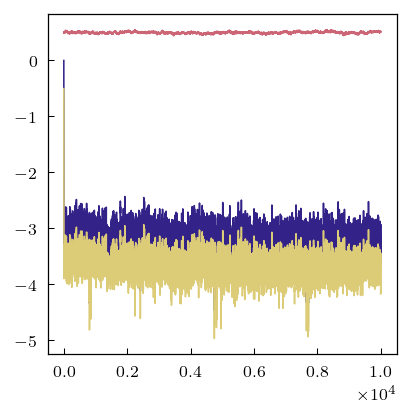

In [18]:
plt.plot(r232q)
plt.plot(displacement_q[0, :])
plt.plot(displacement_q[0, :] - r232q)

In [7]:
def arg_disp_q(topfile, trajfile):
    """Compute the displacement charge contribution of 
    each sensing arginine"""
    u = mda.Universe(topfile, trajfile)
    rq = np.empty((5, len(u.trajectory)))
    for i, r_i in enumerate((217, 223, 226, 229, 232)):
        sel = u.select_atoms(f"protein and resid {r_i}")
        for j, _ in enumerate(u.trajectory):
            rq[i, j] = compute_displacement_charge_sel(u, sel)
    return rq

In [20]:
rq0 = arg_disp_q(topfile, "/project/dinner/scguo/anton-old/civsd_0.dcd")

In [8]:
displacement_q_old = np.load("../../data/raw_feat/displacement_q_0-178.npy")
print(displacement_q_old.shape)

(179, 10000)


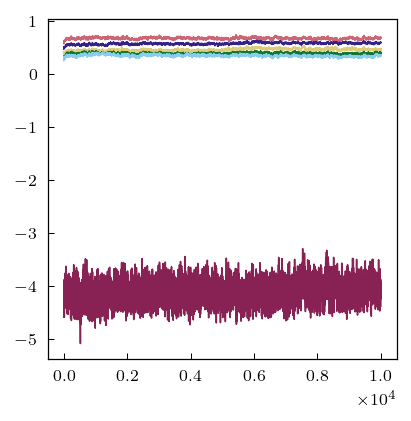

In [25]:
plt.plot(rq0.T)
plt.plot(displacement_q_old[0])

# Old Anton trajectories

In [8]:
from joblib import Parallel, delayed
from multiprocessing import cpu_count
n_jobs = cpu_count()

In [10]:
dcdfiles = [f"/project/dinner/scguo/anton-old/civsd_{i}.dcd" for i in range(179)]

In [12]:
rq_all = Parallel(n_jobs=n_jobs, verbose=40)(
    delayed(arg_disp_q)(topfile, f) for f in dcdfiles)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. 

In [45]:
rq = np.array([t[:, :10000] for t in rq_all])
print(rq.shape)

(179, 5, 10000)


In [46]:
np.save("../../data/raw_feat/displacement_rq_0-178.npy", rq)

In [13]:
displacement_q_old = np.load("../../data/raw_feat/displacement_q_0-178.npy")
print(displacement_q_old.shape)

(179, 10000)


## New Anton trajectories

In [9]:

remove = {1282,
    1283,
    1284,
    1285,
    1286,
    1288,
    1289,
    1290,
    1187,
    1188,
    1189,
    1190,
    1191,
    1197,
    1198,
    1199,
    1203,
    1205,
    1206,
    1207,
    1211,
    1212,
    1213,
    1214,
    1215,
    1225,
    1226,
    1227,
    1228,
    1231,
    1232,
    1233,
    1236,
    1237,
    1238,
    1242,
    1245,
    1246,
    1252,
    1253,
    1260,
    1261,
    1262,
    1263,
    1266,
    1267,
    1268,
    1269,
    1270,
    1271,
    1272,
    1273,
    1274,
    1275,
    1276,
    1277,
    1278,
    1279,
}
files = []
for i in range(179, 295):
    if i == 180:
        continue
    if (i + 1000) not in remove:
        files.append(f"/project/dinner/scguo/anton-old/civsd_{i}.dcd")

In [10]:
from MDAnalysis import transformations

In [10]:
def arg_disp_q_new(topfile, trajfile):
    """Compute the displacement charge contribution of 
    each sensing arginine"""
    u = mda.Universe(topfile, trajfile)
    no_prot = u.atoms
    trans = transformations.wrap(no_prot, compound='residues')
    center = transformations.center_in_box(no_prot, point=(0, 0, 0), wrap=True)
    u.trajectory.add_transformations(trans, center)
    
    rq = np.empty((5, len(u.trajectory)))
    for i, r_i in enumerate((217, 223, 226, 229, 232)):
        sel = u.select_atoms(f"protein and resid {r_i}")
        for j, _ in enumerate(u.trajectory):
            rq[i, j] = compute_displacement_charge_sel(u, sel)
    return rq

In [11]:
# rq_all = Parallel(n_jobs=n_jobs, verbose=20)(
#     delayed(arg_disp_q_new)(topfile, f) for f in files)
rq_all = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(arg_disp_q)(topfile, f) for f in files)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. 

In [18]:
len(rq_all), rq_all[0].shape

(57, (5, 100000))

In [ ]:
for i in rq_all:
    print(i.shape)

(5, 100000)
(5, 100000)
(5, 100000)
(5, 100000)
(5, 100000)
(5, 100000)
(5, 10000)
(5, 10000)
(5, 10360)
(5, 10066)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10558)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10415)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10296)
(5, 10056)
(5, 10000)
(5, 10000)
(5, 10475)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10000)
(5, 10496)
(5, 10527)
(5, 10510)


In [22]:
np.save("../../data/raw_feat/displacement_rq_179-185.npy", rq_all[:6])

In [23]:
np.save("../../data/raw_feat/displacement_rq_185-end.npy", [rq[:, :10000] for rq in rq_all[6:]])

### First frames

In [12]:
def rq_single(struct_file):
    u = mda.Universe(struct_file)
    no_prot = u.atoms
    trans = transformations.wrap(no_prot, compound='residues')
    center = transformations.center_in_box(no_prot, point=(0, 0, 0), wrap=True)
    u.trajectory.add_transformations(trans, center)
    
    rq = np.empty(5)
    for i, r_i in enumerate((217, 223, 226, 229, 232)):
        sel = u.select_atoms(f"protein and resid {r_i}")
        rq[i] = compute_displacement_charge_sel(u, sel)
    return rq

In [13]:
results_all = np.zeros((115, 5))
ix = 0
for i in range(3, 119):
    print(ix)
    if i == 82:
        continue
    files = glob.glob(f"/beagle3/dinner/scguo/anton2-backup/workdir.{i}/*.dms")
    k = ""
    for f in files:
        if not "group" in f: # exclude groups.dms file
            k = f
    print(k)
    results_all[ix, :] = rq_single(k)
    ix += 1

0
/beagle3/dinner/scguo/anton2-backup/workdir.3/civsd.final.dms
1
/beagle3/dinner/scguo/anton2-backup/workdir.4/smd_13_end.final.dms
2
/beagle3/dinner/scguo/anton2-backup/workdir.5/smd_12_end.final.dms
3
/beagle3/dinner/scguo/anton2-backup/workdir.6/smd_13_end.final.2.dms
4
/beagle3/dinner/scguo/anton2-backup/workdir.7/smd_11_end.final.dms
5
/beagle3/dinner/scguo/anton2-backup/workdir.8/smd_28_end.final.dms
6
/beagle3/dinner/scguo/anton2-backup/workdir.9/smd_29_end.final.dms
7
/beagle3/dinner/scguo/anton2-backup/workdir.10/smd_30_end.final.dms
8
/beagle3/dinner/scguo/anton2-backup/workdir.11/smd_31_end.final.dms
9
/beagle3/dinner/scguo/anton2-backup/workdir.12/smd_32_end.final.dms
10
/beagle3/dinner/scguo/anton2-backup/workdir.13/smd_33_end.final.dms
11
/beagle3/dinner/scguo/anton2-backup/workdir.14/smd_34_end.final.dms
12
/beagle3/dinner/scguo/anton2-backup/workdir.15/smd_35_end.final.dms
13
/beagle3/dinner/scguo/anton2-backup/workdir.16/smd_36_end.final.dms
14
/beagle3/dinner/scguo/a

In [14]:
displacement_rq = np.zeros((115, 10001))
displacement_rq[:, 1:] = rq_all
displacement_rq[:, 0] = results_all

ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 2.

In [ ]:
np.save("../../data/raw_feat/displacement_rq", displacement_rq)

# Plot against CVs

In [14]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy"))
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy"))
sb_arr = np.concatenate(sb_trajs)
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[8] # 50 ns lag time
# weights
weights = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)[0] # 0.1 ns lag time

In [16]:
import extq

In [18]:
# bin against S4 CVs
dist_trajs = [t[:, 0] for t in cv_trajs]
rot_trajs = [t[:, 1] for t in cv_trajs]
xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
xe = np.linspace(xmin, xmax, 100)
ye = np.linspace(ymin, ymax, 100)
q_binned = extq.projection.average2d(dist_trajs[:179], rot_trajs[:179], displacement_q_old, weights[:179], xe, ye)

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


[(-9.5, 8.5), (-130.0, 85.0)]

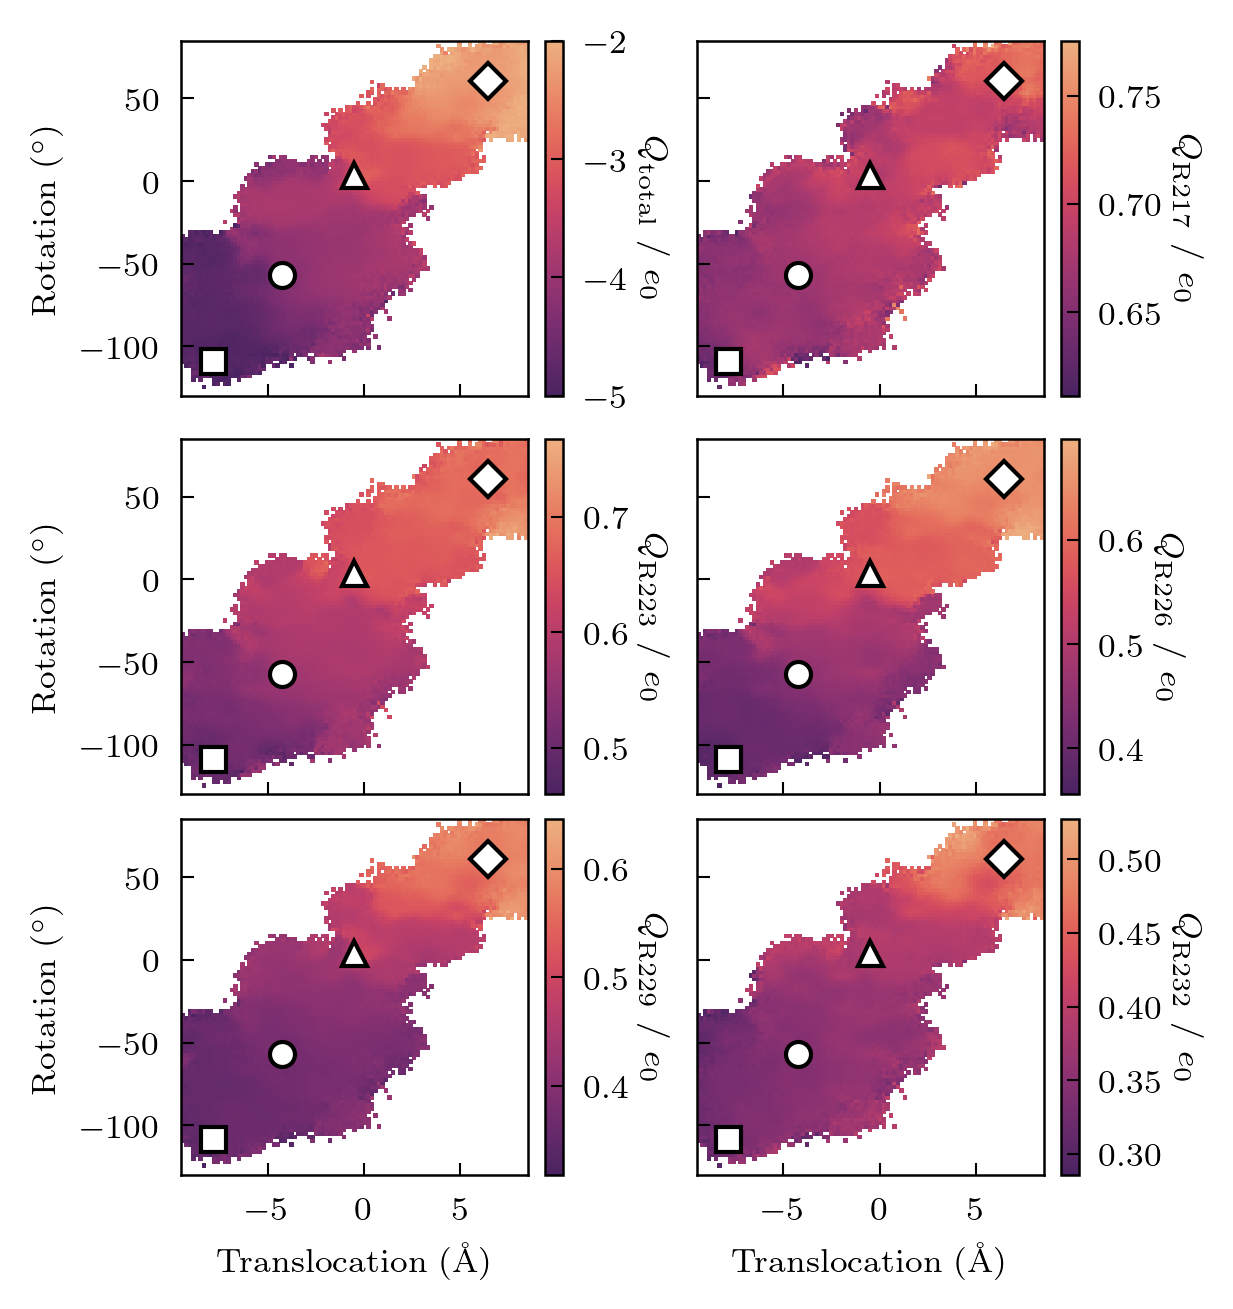

In [54]:
f, axs = plt.subplots(3, 2, figsize=(4, 4.25), dpi=300, sharex=True, sharey=True, constrained_layout=True)
h = axs[0,0].pcolor(xe, ye, q_binned.T, cmap='flare_r', vmin=-5, vmax=-2)
plotting.format_cvs(axs[0,0], ms=6)
cb = plt.colorbar(h, ax=axs[0,0])
cb.set_label(r"$Q_{\mathrm{total}}$ / $e_0$", rotation=-90, labelpad=10)

cb_titles = (r"$Q_{\mathrm{R217}}$ / $e_0$", 
             r"$Q_{\mathrm{R223}}$ / $e_0$",
             r"$Q_{\mathrm{R226}}$ / $e_0$", 
             r"$Q_{\mathrm{R229}}$ / $e_0$",
             r"$Q_{\mathrm{R232}}$ / $e_0$")
for r, ax, title in zip(range(5), axs.flat[1:], cb_titles):
    rq = [t[r, :10000] for t in rq_all]
    rq_binned = extq.projection.average2d(dist_trajs[:179], rot_trajs[:179], rq, weights[:179], xe, ye)
    h = ax.pcolor(xe, ye, rq_binned.T, cmap='flare_r')
    plotting.format_cvs(ax, ms=6)
    cb = plt.colorbar(h, ax=ax)
    cb.set_label(title, rotation=-90, labelpad=10)
    
for ax in axs.flat:
    ax.label_outer()
axs[0,0].set(xlim=[xmin, xmax], ylim=[ymin, ymax])

In [37]:
sb_names = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_names.append(f"{r} C$_\\alpha$-{n} C$_\\alpha$")
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")

/scratch/local/jobs/4083250/ipykernel_708818/2468588004.py:21: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7fa625c89d90> has a label of '_blank' which cannot be automatically added to the legend.
  f.legend(bbox_to_anchor=(0.5, 1.07), loc='center', ncol=3, labels=["_blank", 'Down–', 'Down', 'Up'])


[(3.0, 16.0), (3.0, 16.0)]

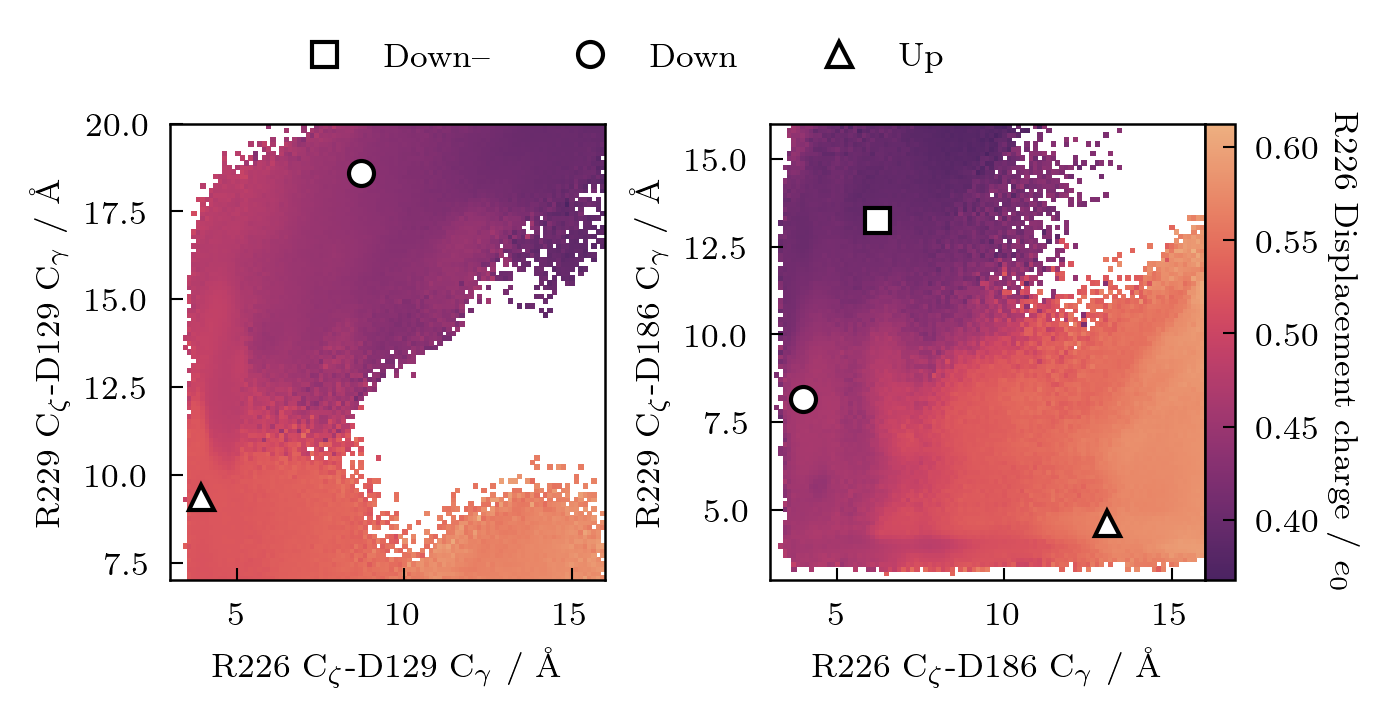

In [40]:
f, axes = plt.subplots(1, 2, figsize=(4, 2), dpi=300, constrained_layout=True)

range0 = [[3, 16], [7, 20]]
range1 = [[3, 16], [3, 16]]
nbin = 100
ri = 2
for ((sb1, sb2), ax, r) in zip(((42, 48), (47, 53)), axes, (range0, range1)):
    sb1_trajs = [t[:, sb1] * 10 for t in sb_trajs]
    sb2_trajs = [t[:, sb2] * 10 for t in sb_trajs]
    xlim = np.linspace(*r[0], nbin)
    ylim = np.linspace(*r[1], nbin)
    rq = [t[ri, :10000] for t in rq_all]
    rq_binned = extq.projection.average2d(sb1_trajs[:179], sb2_trajs[:179], rq, weights[:179], xlim, ylim)
    h = ax.pcolor(xlim, ylim, rq_binned.T, cmap='flare_r')
    ax.set(
        xlabel=f"{sb_names[sb1]} / Å",
        ylabel=f"{sb_names[sb2]} / Å",
    )
    plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=6)

f.legend(bbox_to_anchor=(0.5, 1.07), loc='center', ncol=3, labels=["_blank", 'Down–', 'Down', 'Up'])
cb = pplt.colorbar(h, ax=axes[-1])
cb.solids.set(alpha=1)
cb.set_label("R226 Displacement charge / $e_0$", rotation=-90, labelpad=10)
axes[0].set(xlim=range0[0], ylim=range0[1])
axes[1].set(xlim=range1[0], ylim=range1[1])

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom
/scratch/local/jobs/4083250/ipykernel_708818/2822162638.py:21: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7fa626d2c490> has a label of '_blank' which cannot be automatically added to the legend.
  f.legend(bbox_to_anchor=(0.5, 1.07), loc='center', ncol=3, labels=["_blank", 'Down–', 'Down', 'Up'])


[(3.0, 16.0), (3.0, 16.0)]

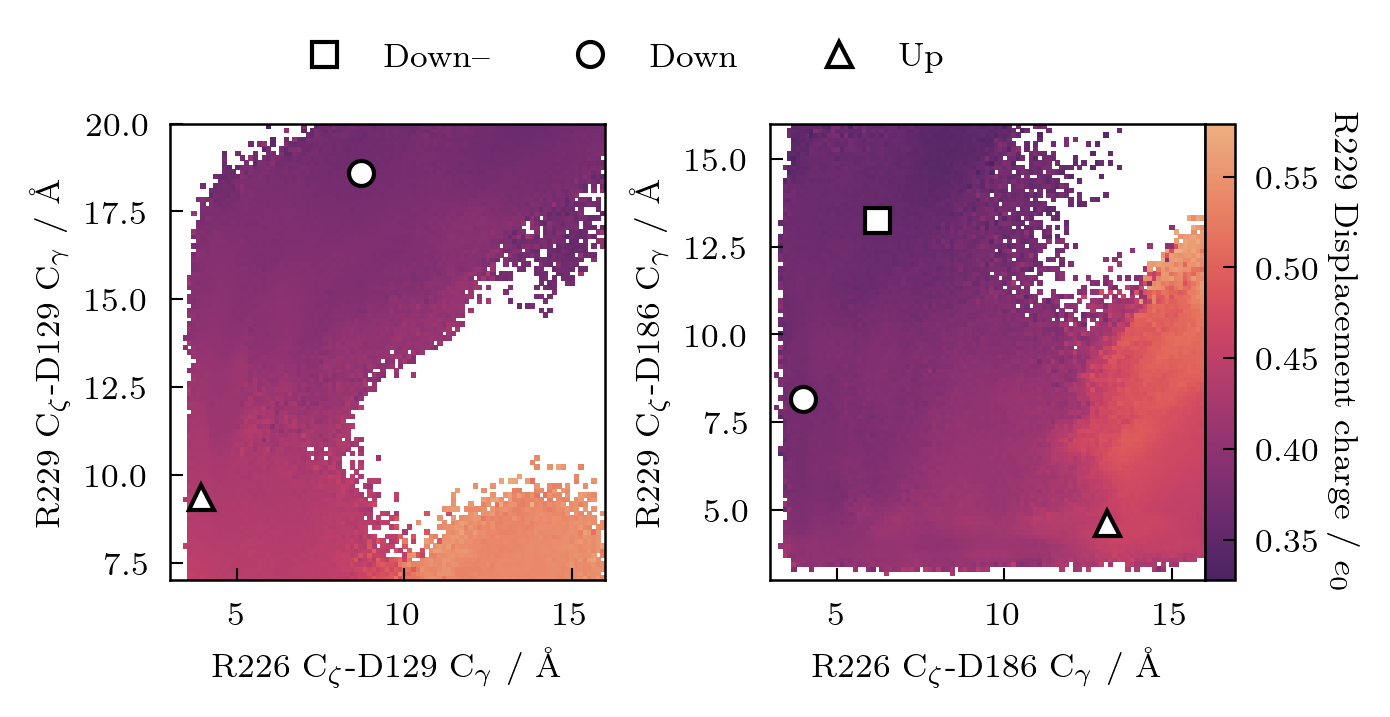

In [41]:
f, axes = plt.subplots(1, 2, figsize=(4, 2), dpi=300, constrained_layout=True)

range0 = [[3, 16], [7, 20]]
range1 = [[3, 16], [3, 16]]
nbin = 100
ri = 3
for ((sb1, sb2), ax, r) in zip(((42, 48), (47, 53)), axes, (range0, range1)):
    sb1_trajs = [t[:, sb1] * 10 for t in sb_trajs]
    sb2_trajs = [t[:, sb2] * 10 for t in sb_trajs]
    xlim = np.linspace(*r[0], nbin)
    ylim = np.linspace(*r[1], nbin)
    rq = [t[ri, :10000] for t in rq_all]
    rq_binned = extq.projection.average2d(sb1_trajs[:179], sb2_trajs[:179], rq, weights[:179], xlim, ylim)
    h = ax.pcolor(xlim, ylim, rq_binned.T, cmap='flare_r')
    ax.set(
        xlabel=f"{sb_names[sb1]} / Å",
        ylabel=f"{sb_names[sb2]} / Å",
    )
    plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=6)

f.legend(bbox_to_anchor=(0.5, 1.07), loc='center', ncol=3, labels=["_blank", 'Down–', 'Down', 'Up'])
cb = pplt.colorbar(h, ax=axes[-1])
cb.solids.set(alpha=1)
cb.set_label("R229 Displacement charge / $e_0$", rotation=-90, labelpad=10)
axes[0].set(xlim=range0[0], ylim=range0[1])
axes[1].set(xlim=range1[0], ylim=range1[1])

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom
/scratch/local/jobs/4083250/ipykernel_708818/3518320745.py:21: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7fa625465c70> has a label of '_blank' which cannot be automatically added to the legend.
  f.legend(bbox_to_anchor=(0.5, 1.07), loc='center', ncol=3, labels=["_blank", 'Down–', 'Down', 'Up'])


[(3.0, 16.0), (3.0, 16.0)]

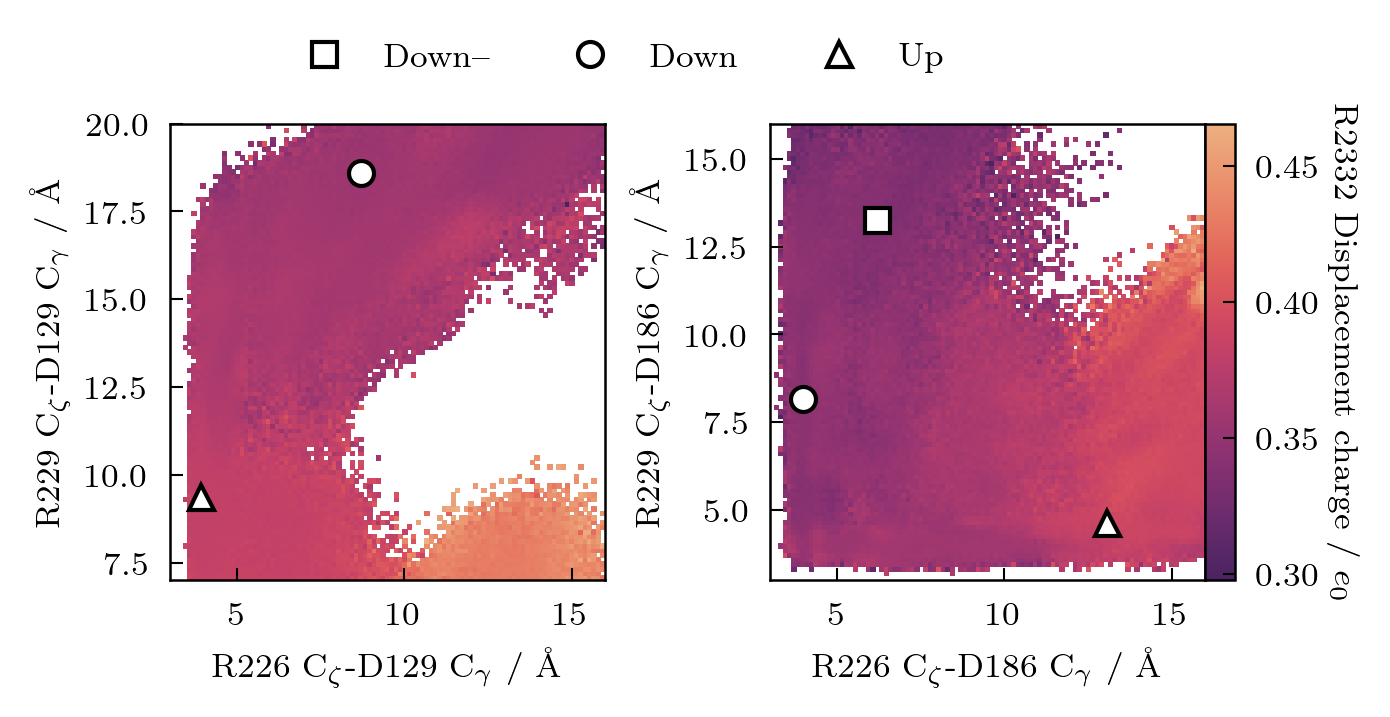

In [42]:
f, axes = plt.subplots(1, 2, figsize=(4, 2), dpi=300, constrained_layout=True)

range0 = [[3, 16], [7, 20]]
range1 = [[3, 16], [3, 16]]
nbin = 100
ri = 4
for ((sb1, sb2), ax, r) in zip(((42, 48), (47, 53)), axes, (range0, range1)):
    sb1_trajs = [t[:, sb1] * 10 for t in sb_trajs]
    sb2_trajs = [t[:, sb2] * 10 for t in sb_trajs]
    xlim = np.linspace(*r[0], nbin)
    ylim = np.linspace(*r[1], nbin)
    rq = [t[ri, :10000] for t in rq_all]
    rq_binned = extq.projection.average2d(sb1_trajs[:179], sb2_trajs[:179], rq, weights[:179], xlim, ylim)
    h = ax.pcolor(xlim, ylim, rq_binned.T, cmap='flare_r')
    ax.set(
        xlabel=f"{sb_names[sb1]} / Å",
        ylabel=f"{sb_names[sb2]} / Å",
    )
    plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=6)

f.legend(bbox_to_anchor=(0.5, 1.07), loc='center', ncol=3, labels=["_blank", 'Down–', 'Down', 'Up'])
cb = pplt.colorbar(h, ax=axes[-1])
cb.solids.set(alpha=1)
cb.set_label("R232 Displacement charge / $e_0$", rotation=-90, labelpad=10)
axes[0].set(xlim=range0[0], ylim=range0[1])
axes[1].set(xlim=range1[0], ylim=range1[1])

# Contribution of each Arg to total displacement charge

In [55]:
# states to do stopping
dist = cv_arr[:1_790_000, 0]
rot = cv_arr[:1_790_000, 1]
sb1 = sb_arr[:1_790_000, 42]  # R226-D129
sb2 = sb_arr[:1_790_000, 47]  # R226-D186
sb3 = sb_arr[:1_790_000, 48]  # R229-D129
sb4 = sb_arr[:1_790_000, 53]  # R229-D186
sb5 = sb_arr[:1_790_000, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [59]:
dq = np.array([t[:, :10000] for t in rq_all])
np.hstack(dq).shape

(5, 1790000)

In [64]:
down_charge = np.mean(np.concatenate(displacement_q_old)[down_ids])
up_charge = np.mean(np.concatenate(displacement_q_old)[up_ids])
diff = up_charge - down_charge
print(f"Total displacement charge (down to up): {diff:.3f} e0")
for i in range(5):
    down_r = np.mean(np.hstack(dq)[i, down_ids])
    up_r = np.mean(np.hstack(dq)[i, up_ids])
    print(f"R{i} displacement charge: {up_r - down_r:.3f} e0")

Total displacement charge (down to up): 0.884 e0
R0 displacement charge: 0.019 e0
R1 displacement charge: 0.076 e0
R2 displacement charge: 0.116 e0
R3 displacement charge: 0.089 e0
R4 displacement charge: 0.047 e0
